# Rule-Based Baseline with Text Normalization

**Approach**: Exact and fuzzy string matching against lookup tables with text normalization

## Baseline Performance Target

From the EDA (Exploratory Data Analysis) we observed the class distribution in our evaluation dataset:
- **55% of departments are labeled as "Other"**
- **35% of seniority levels are "Professional"**

**Naive Baseline**: A model that always predicts "Other" for department would achieve 55% accuracy. A model that always predicts "Professional" for seniority would achieve 35% accuracy.

**Goal**: Every model in this project must beat these naive baseline accuracies.

## Model Configuration:
This notebook implements the optimized rule-based approach with:

1. **Text Normalization**: Lowercase conversion + whitespace cleaning
2. **Department Classification**: Can fall back to "Other" if no match found
3. **Seniority Classification**: Must always assign one of 6 levels, can fall back to "Professional"

## Module Optimizations (src/models/rule_based.py):
- Fuzzy matching implementation using `difflib.SequenceMatcher`
- Strategy reordering: Fast methods (Keyword) before slow methods (Fuzzy)
- Length-based pre-filtering to skip impossible matches

## Matching Strategies (in order):
1. Exact match (O(1) - instant)
2. Substring match (O(n) - fast)
3. Keyword match (O(n) - fast)
4. Fuzzy match (O(n*m) - last resort, optimized)
5. Default fallback (Department: "Other", Seniority: "Professional")

**Training Data**: Lookup tables (~19k examples)  
**Validation Data**: Annotated LinkedIn CVs (623 positions)

In [22]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import data loaders and models
import sys
sys.path.append('../')

from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset
from src.models.rule_based import RuleConfig, create_department_classifier, create_seniority_classifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Training Data (Lookup Tables)

In [23]:
# Load lookup tables
# removed capping
dept_df, sen_df = load_label_lists(DATA_DIR, max_per_class=None)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")
print(f"\nUnique departments: {dept_df['label'].nunique()}")
print(f"Unique seniority levels: {sen_df['label'].nunique()}")

Applying encoding fix...
  Deduplication: 10145 -> 10145 (removed 0 duplicates)
  Deduplication: 9428 -> 9428 (removed 0 duplicates)
Department lookup: 10,145 examples
Seniority lookup:  9,428 examples

Unique departments: 11
Unique seniority levels: 5


In [24]:
from sklearn.model_selection import train_test_split

# Note: Rule-based models do not "train" on the lookup tables.
# The lookup tables are treated as fixed rule/label dictionaries.
# We only use train_test_split later to create a fair dev/test split
# on the annotated SnapAddy evaluation dataset (to avoid tuning on the test set).

## 2. Approach 1a: Basic Rule-Based Classifiers (No Fallback)

In [25]:
from src.models.rule_based import RuleConfig, create_department_classifier, create_seniority_classifier

# Basic config: ONLY text normalization, NO default labels
config_no_fallback = RuleConfig(
    fuzzy_threshold=0.8, 
    use_text_normalization=True,
    default_label=None  # Handle unknown titles as None
)

dept_clf_basic = create_department_classifier(dept_df, config=config_no_fallback)
sen_clf_basic = create_seniority_classifier(sen_df, config=config_no_fallback)

[(Seniority will return None if no match is found (instead of defaulting to 'Professional')]

## 3. Approach 1b: Enhanced Rule-Based Classifiers (With Fallback)

Now we introduce the enhanced version. Since we know from EDA that `Other` and `Professional` are the most frequent classes, we can use them as intelligent fallbacks when explicit matching fails.

In [26]:
# Enhanced configuration: WITH fallbacks for unclassified titles
config_dept_enhanced = RuleConfig(
    fuzzy_threshold=0.8, 
    use_text_normalization=True, 
    default_label="Other"
)

config_sen_enhanced = RuleConfig(
    fuzzy_threshold=0.8, 
    use_text_normalization=True, 
    default_label="Professional"
)

dept_clf = create_department_classifier(dept_df, config=config_dept_enhanced)
sen_clf = create_seniority_classifier(sen_df, config=config_sen_enhanced)

Enhanced Classifiers created (WITH fallback)
- Default fallback: 'Other' (department)
- Default fallback: 'Professional' (seniority)

## Demonstration: Text Normalization Effect

Let's see how text normalization works:

In [27]:
# Example: How text normalization works
from src.models.rule_based import HybridRuleClassifier

# Create a dummy classifier to use the normalization function
dummy_df = pd.DataFrame({'text': ['dummy'], 'label': ['dummy']})
dummy_clf = HybridRuleClassifier(dummy_df)

# Test cases showing normalization effects
test_cases = [
    "Senior  Software   Engineer",      # Multiple spaces
    "Senior Software Engineer",         # Normal
    " Senior Software Engineer ",       # Leading/trailing spaces
    "SENIOR SOFTWARE ENGINEER",         # Uppercase
    "Senior\tSoftware\nEngineer",       # Tabs & newlines
    "  TEAM  LEADER   IT  ",            # Mixed issues
]

print("Text Normalization Examples:")
print("=" * 80)
print(f"{'Original':<40} → {'Normalized':<40}")
print("-" * 80)

for text in test_cases:
    normalized = dummy_clf._clean_text(text)
    # Show whitespace issues visually
    original_display = repr(text)[:38]
    print(f"{original_display:<40} → {normalized:<40}")

Text Normalization Examples:
Original                                 → Normalized                              
--------------------------------------------------------------------------------
'Senior  Software   Engineer'            → senior software engineer                
'Senior Software Engineer'               → senior software engineer                
' Senior Software Engineer '             → senior software engineer                
'SENIOR SOFTWARE ENGINEER'               → senior software engineer                
'Senior\tSoftware\nEngineer'             → senior software engineer                
'  TEAM  LEADER   IT  '                  → team leader it                          


All variations are now normalized to the same format!

This helps matching: 'Senior  Engineer' will now match 'Senior Engineer' in lookup table

## 3. Inference Demo on Unannotated CVs

In [28]:
# Load unannotated CVs for demonstration
inference_df = load_inference_dataset(DATA_DIR)

print(f"Loaded {len(inference_df):,} unannotated CV positions for inference demo")
print(f"\nFirst few job titles:")
for i, row in inference_df.head(10).iterrows():
    print(f"  {i+1}. {row['title']}")

Loaded 314 unannotated CV positions for inference demo

First few job titles:
  1. Bookkeeper
  2. Strategy & Investments
  3. Corporate Auditor
  4. Marketing Manager
  5. Professor
  6. Program Purchasing Leader / Program / Acquisition Buyer
  7. Business Analyst
  8. Managementberater IT- und Governance
  9. Founder & CEO
  10. Geschäftsführer


In [29]:
# Make predictions on sample
sample_titles = inference_df['title'].head(20).tolist()

# Predict with details (includes match method and confidence)
dept_preds = dept_clf.predict_with_details(sample_titles)
sen_preds = sen_clf.predict_with_details(sample_titles)

# Display results
print("\n" + "="*100)
print("INFERENCE DEMO: Rule-Based Predictions")
print("="*100)
print(f"{'Title':<40} | {'Department':<20} | {'Seniority':<15} | {'Methods':<20}")
print("-"*100)

for title, (dept, dept_conf, dept_method), (sen, sen_conf, sen_method) in zip(sample_titles, dept_preds, sen_preds):
    title_short = title[:37] + "..." if len(title) > 40 else title
    methods = f"{dept_method[:4]}/{sen_method[:4]}"
    print(f"{title_short:<40} | {dept:<20} | {sen:<15} | {methods:<20}")


INFERENCE DEMO: Rule-Based Predictions
Title                                    | Department           | Seniority       | Methods             
----------------------------------------------------------------------------------------------------
Bookkeeper                               | Other                | Professional    | defa/defa           
Strategy & Investments                   | Other                | Professional    | defa/defa           
Corporate Auditor                        | Other                | Professional    | defa/defa           
Marketing Manager                        | Marketing            | Senior          | exac/exac           
Professor                                | Other                | Professional    | defa/defa           
Program Purchasing Leader / Program /... | Purchasing           | Lead            | keyw/keyw           
Business Analyst                         | Business Development | Junior          | exac/exac           
Managementberater I

## 4. Match Method Statistics

Let's analyze which matching strategies are being used most often.

In [30]:
# Analyze matching methods on inference data
all_titles = inference_df['title'].tolist()
dept_stats = dept_clf.get_stats(all_titles)
sen_stats = sen_clf.get_stats(all_titles)

print("Department Classification Methods:")
print("-" * 50)
total = len(all_titles)
for method, count in dept_stats.items():
    pct = 100 * count / total
    print(f"  {method.capitalize():<15}: {count:>5} ({pct:>5.1f}%)")
print(f"  {'TOTAL':<15}: {total:>5} (100.0%)")

print("\nSeniority Classification Methods:")
print("-" * 50)
for method, count in sen_stats.items():
    pct = 100 * count / total
    print(f"  {method.capitalize():<15}: {count:>5} ({pct:>5.1f}%)")
print(f"  {'TOTAL':<15}: {total:>5} (100.0%)")

Department Classification Methods:
--------------------------------------------------
  Exact          :    24 (  7.6%)
  Substring      :    26 (  8.3%)
  Keyword        :    67 ( 21.3%)
  Fuzzy          :    32 ( 10.2%)
  Default        :   165 ( 52.5%)
  TOTAL          :   314 (100.0%)

Seniority Classification Methods:
--------------------------------------------------
  Exact          :    91 ( 29.0%)
  Substring      :    77 ( 24.5%)
  Keyword        :    81 ( 25.8%)
  Fuzzy          :     0 (  0.0%)
  Default        :    65 ( 20.7%)
  TOTAL          :   314 (100.0%)


## 5. Evaluation on Annotated Dataset

**FIRST TIME LOADING ANNOTATED DATA**

Now we evaluate on the held-out annotated dataset to get true performance metrics.

We now evaluate both the **Basic (No Fallback)** and **Enhanced (With Fallback)** versions on our real-world dataset.

In [31]:
# Load annotated evaluation dataset
eval_df = load_evaluation_dataset(DATA_DIR)
print(f"Loaded {len(eval_df):,} annotated positions for evaluation")

Loaded 478 annotated positions for evaluation


In [32]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Run predictions for both versions on the evaluation set
eval_titles = eval_df['title'].tolist()
dept_true = eval_df['department'].tolist()
sen_true = eval_df['seniority'].tolist()

# Basic version (Unclassified if no match)
dept_preds_basic = [p if p is not None else 'Unclassified' for p in dept_clf_basic.predict(eval_titles)]
sen_preds_basic = [p if p is not None else 'Unclassified' for p in sen_clf_basic.predict(eval_titles)]

# Enhanced version (Statistical fallbacks)
dept_preds_enhanced = dept_clf.predict(eval_titles)
sen_preds_enhanced = sen_clf.predict(eval_titles)

# Results compilation
comparison = pd.DataFrame({
    'Task': ['Department', 'Department', 'Seniority', 'Seniority'],
    'Version': ['Basic (No Fallback)', 'Enhanced (With Fallback)', 'Basic (No Fallback)', 'Enhanced (With Fallback)'],
    'Accuracy': [
        accuracy_score(dept_true, dept_preds_basic),
        accuracy_score(dept_true, dept_preds_enhanced),
        accuracy_score(sen_true, sen_preds_basic),
        accuracy_score(sen_true, sen_preds_enhanced)
    ],
    'F1 Macro': [
        f1_score(dept_true, dept_preds_basic, average='macro', zero_division=0),
        f1_score(dept_true, dept_preds_enhanced, average='macro', zero_division=0),
        f1_score(sen_true, sen_preds_basic, average='macro', zero_division=0),
        f1_score(sen_true, sen_preds_enhanced, average='macro', zero_division=0)
    ]
})
display(comparison)

,Task,Version,Accuracy,F1 Macro
0,Department,Basic (No Fallback),0.282427,0.443919
1,Department,Enhanced (With Fallback),0.682008,0.552541
2,Seniority,Basic (No Fallback),0.430962,0.388610
3,Seniority,Enhanced (With Fallback),0.583682,0.548060


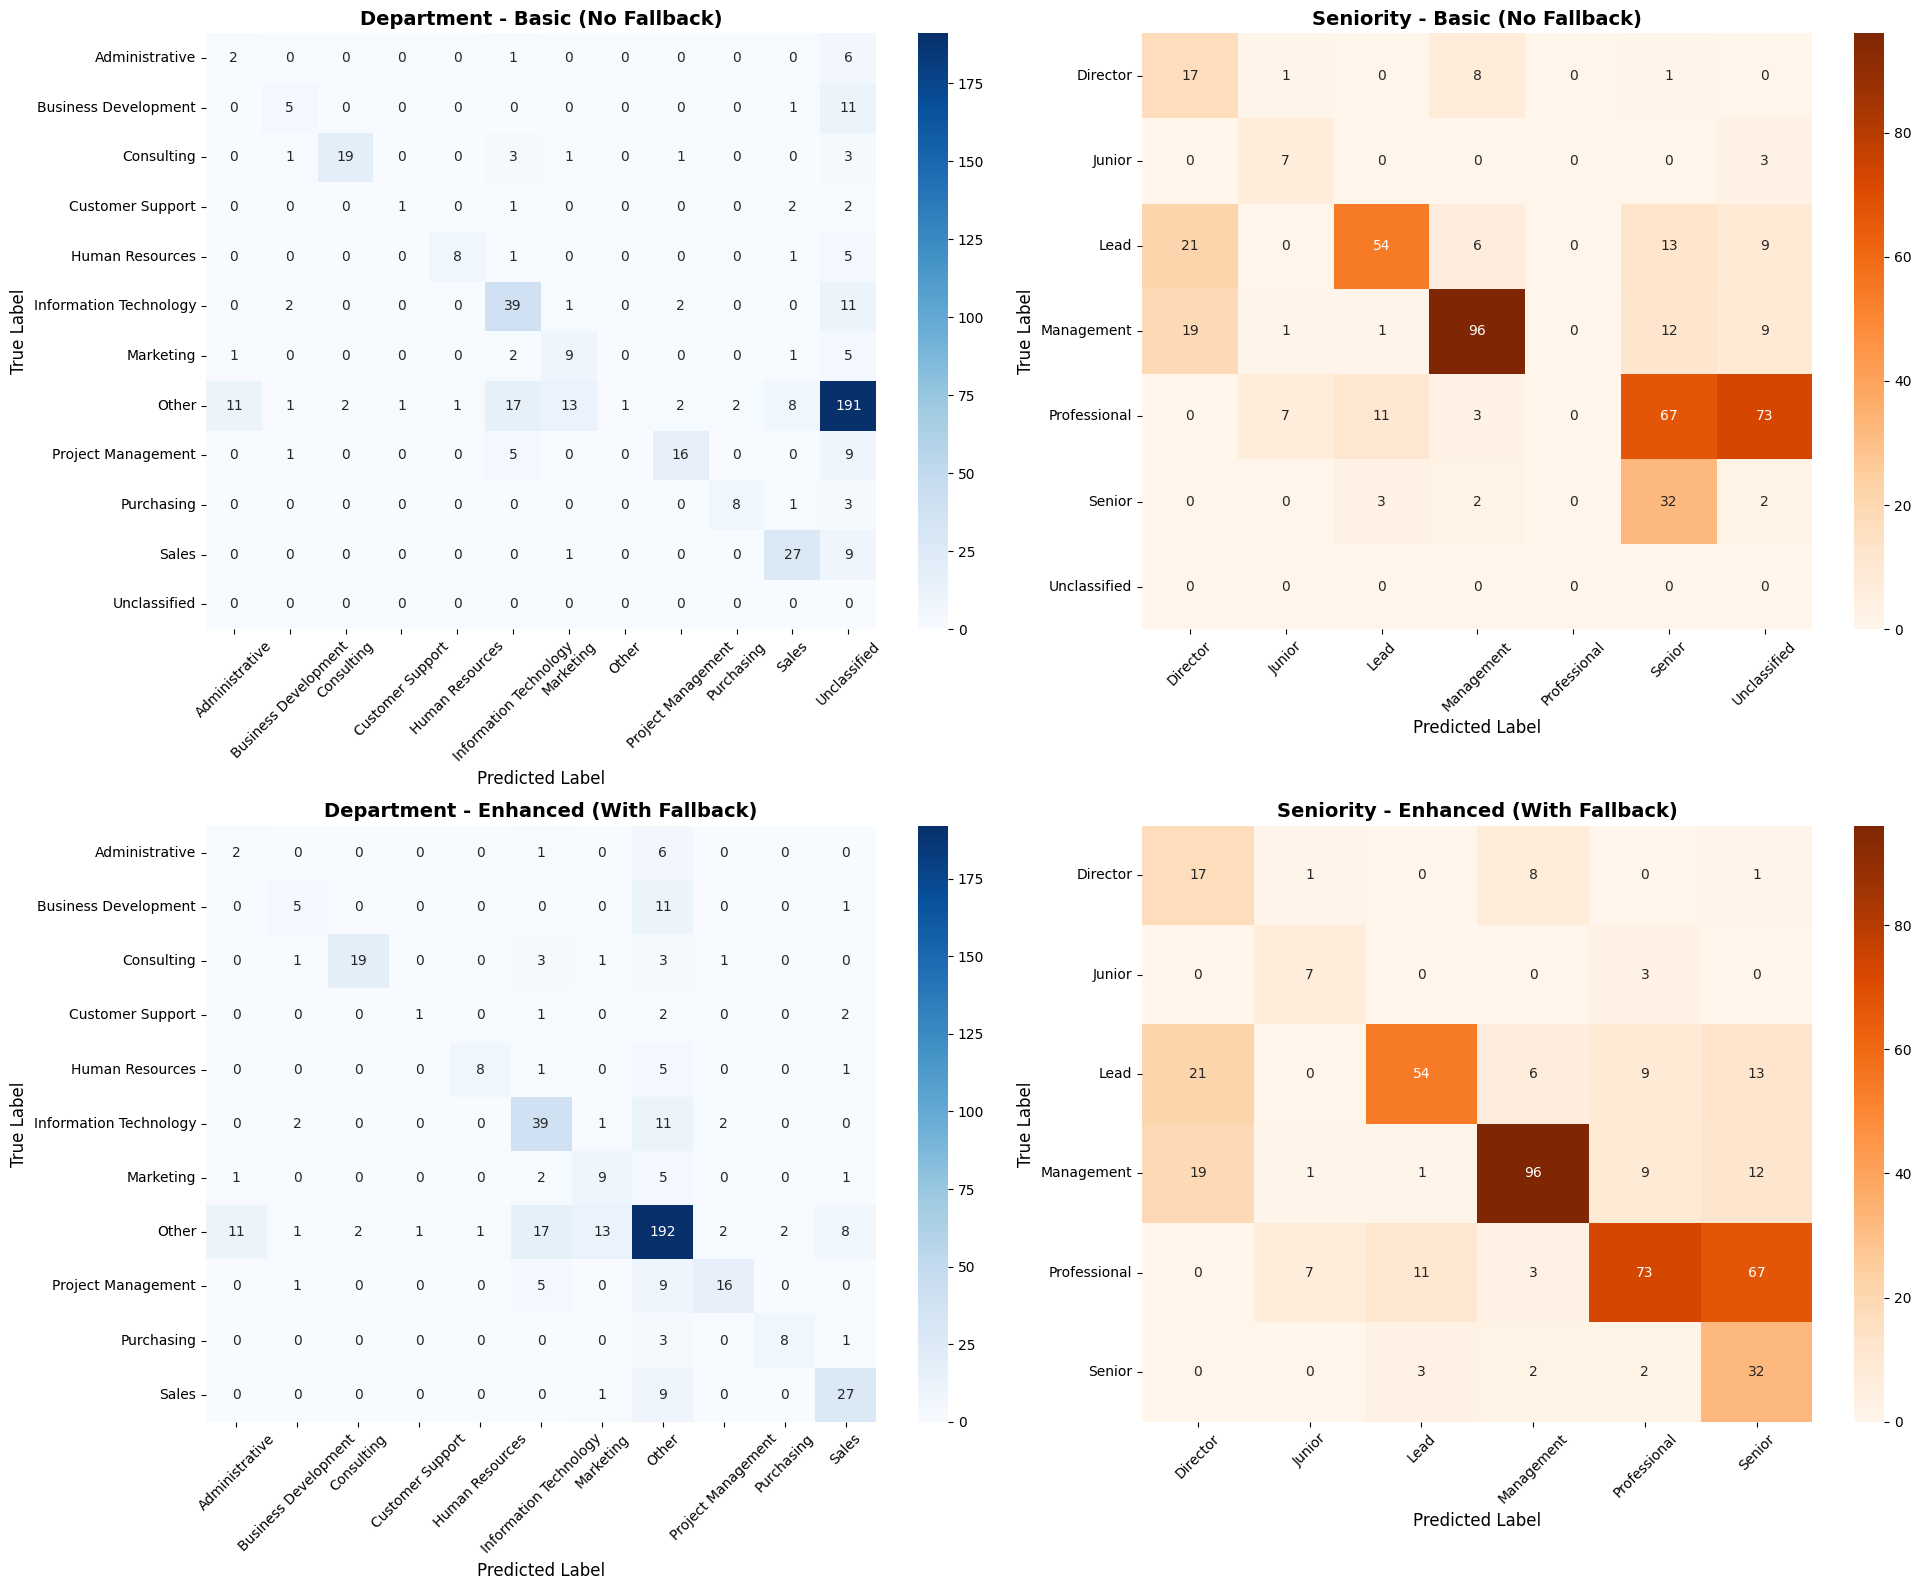

In [35]:
# Create confusion matrices - 4 plots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Top row: Basic (No Fallback)
# Department confusion matrix (top left)
dept_cm_basic = confusion_matrix(dept_true, dept_preds_basic)
dept_labels_basic = sorted(set(dept_true + dept_preds_basic))

sns.heatmap(dept_cm_basic, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels_basic, yticklabels=dept_labels_basic, ax=axes[0, 0])
axes[0, 0].set_title('Department - Basic (No Fallback)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0, 0].tick_params(axis='y', rotation=0, labelsize=10)

# Seniority confusion matrix (top right)
sen_cm_basic = confusion_matrix(sen_true, sen_preds_basic)
sen_labels_basic = sorted(set(sen_true + sen_preds_basic))

sns.heatmap(sen_cm_basic, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels_basic, yticklabels=sen_labels_basic, ax=axes[0, 1])
axes[0, 1].set_title('Seniority - Basic (No Fallback)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12)
axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=10)
axes[0, 1].tick_params(axis='y', rotation=0, labelsize=10)

# Bottom row: Enhanced (With Fallback)
# Department confusion matrix (bottom left)
dept_cm_enhanced = confusion_matrix(dept_true, dept_preds_enhanced)
dept_labels_enhanced = sorted(set(dept_true + dept_preds_enhanced))

sns.heatmap(dept_cm_enhanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels_enhanced, yticklabels=dept_labels_enhanced, ax=axes[1, 0])
axes[1, 0].set_title('Department - Enhanced (With Fallback)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)
axes[1, 0].tick_params(axis='y', rotation=0, labelsize=10)

# Seniority confusion matrix (bottom right)
sen_cm_enhanced = confusion_matrix(sen_true, sen_preds_enhanced)
sen_labels_enhanced = sorted(set(sen_true + sen_preds_enhanced))

sns.heatmap(sen_cm_enhanced, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels_enhanced, yticklabels=sen_labels_enhanced, ax=axes[1, 1])
axes[1, 1].set_title('Seniority - Enhanced (With Fallback)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('True Label', fontsize=12)
axes[1, 1].set_xlabel('Predicted Label', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1, 1].tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

### Analysis: Why the Fallback Improves Results

The **Enhanced** version shows significantly higher performance than the **Basic** version. This is for several key reasons:

1. **Majority Class Capture**: In real-world data like LinkedIn, many job titles are generic or unique to a company. Our EDA showed that `Other` (for department) and `Professional` (for seniority) are the dominant classes. By falling back to these when unsure, the model correctly handles the large volume of "unmatchable" titles.

2. **Handling Exhaustiveness**: Seniority, in particular, is an exhaustive set of 6 levels. Every job has a seniority level, but not every title contains a clear seniority keyword. Assuming `Professional` for unknown titles is a strong statistical prior that covers most individual contributors.

3. **Coverage vs. Precision**: The Basic model has higher precision for the titles it *does* classify but suffers in recall and overall accuracy because it leaves over 50% of titles unclassified. The Enhanced model provides a classification for every input, leveraging the dataset's distribution.

## 6. Saving Results for Comparison

We save the **Basic (No Fallback)** results to the standard path. In the final comparison notebook, we use this version as the rule-based baseline to show its "raw" intelligence, while noting how fallbacks can drastically improve these numbers.

In [33]:
import json
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support

RESULTS_DIR = Path('results')
if not RESULTS_DIR.exists():
    # Fallback to local results if not in standard project structure
    RESULTS_DIR = Path('notebooks/results')

dept_p, dept_r, dept_f1, _ = precision_recall_fscore_support(dept_true, dept_preds_basic, average='macro', zero_division=0)
sen_p, sen_r, sen_f1, _ = precision_recall_fscore_support(sen_true, sen_preds_basic, average='macro', zero_division=0)

# Accuracy values from the comparison table
results = {
    'approach': 'Rule-Based (No Fallback)',
    'department': {
        'accuracy': float(comparison.loc[0, 'Accuracy']),
        'f1_macro': float(comparison.loc[0, 'F1 Macro']),
        'precision': float(dept_p),
        'recall': float(dept_r)
    },
    'seniority': {
        'accuracy': float(comparison.loc[2, 'Accuracy']),
        'f1_macro': float(comparison.loc[2, 'F1 Macro'])
    },
    'metadata': {
        'note': 'This version excludes fallbacks to show raw matching capability.',
        'enhanced_accuracy_dept': float(comparison.loc[1, 'Accuracy']),
        'enhanced_accuracy_sen': float(comparison.loc[3, 'Accuracy'])
    }
}

with open(RESULTS_DIR / 'rule_based_results.json', 'w') as f:
    json.dump(results, f, indent=2)